In [86]:
from standardInclude import *

In [87]:
path = "/home/jlab/g-2/caloTrackMatching/data/run2c/"; dataset='Run 2C'
#path = "/home/jlab/g-2/caloTrackMatching/data/endgame/"; dataset='EndGame'
#path = "/home/jlab/g-2/caloTrackMatching/data/9day/"; dataset='9 day'
files = os.listdir(path)
print(files)
names = [x.split("_")[0] for x in files]
print(names)

to_fit = "width"

fs = {}
for file in files:
    name = file.split("_")[0]
    fs[name] = r.TFile(path+file)
    fs[name].ls()

['tracks_run2c.root', 'clusters_run2c.root', 'matchedTracks_run2c.root']
['tracks', 'clusters', 'matchedTracks']
TFile**		/home/jlab/g-2/caloTrackMatching/data/run2c/tracks_run2c.root	
 TFile*		/home/jlab/g-2/caloTrackMatching/data/run2c/tracks_run2c.root	
  KEY: TH3I	trackerBeamPos;1	Tracker Beam Position vs. Time
  KEY: TH3I	trackerCaloPos;1	Tracker Calo Face Position vs. Time
  KEY: TH3I	trackerBeamPosRand;1	Tracker Beam Position vs. Rand Time
  KEY: TH3I	trackerCaloPosRand;1	Tracker Calo Face Position vs. Rand Time
  KEY: TH3I	trackerCaloPos_noRadialField;1	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time
  KEY: TH3I	trackerCaloPos_noRadialFieldRand;1	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time
  KEY: TH2D	trackerDeltaPosition_vs_Time;1	Vertical Drift of Decay Positrons: Difference Between Naive and Full Extrapolation
TFile**		/home/jlab/g-2/caloTrackMatching/data/run2c/clusters_run2c.root	
 TFile*		/home/jlab/g-2/caloTrackMatching/data/run2c/

In [88]:
allFitResults = {}

In [89]:
station = 12
calo = station+1

---

### First create a function which will act as a standard pool from which we can pull our fit functions, just for ease of switching between them

In [90]:
def fitfunc(choice, fitrange, params=None):
    tlow, thigh = fitrange
    if(choice is 0):
        func = r.TF1("func","[0] + [1] - [1]/(TMath::Exp([2]*x)) + [3]*(x)",tlow,thigh)
        func.SetParNames("C", "A", "#tau", "m")
        if(params is None):
            paramVec = [1,10,1,-0.0001,10]
        else:
            paramVec = params
        for i,xi in enumerate(paramVec):
            func.SetParameter(i,xi)
        return (func,paramVec)
    elif(choice is 1):
        func = r.TF1("func","pol1",tlow,thigh)
        func.SetParNames("C", "m")
        if(params is None):
            params = [1,-0.00001]
        for i,xi in enumerate(params):
            func.SetParameter(i,xi)
        return (func, params)
    else:
        print("Invalid choice")
        return -1

---

# Lets start with the tracker-only information


In [91]:
name = 'tracks'
f = fs[name]
f.ls()

TFile**		/home/jlab/g-2/caloTrackMatching/data/run2c/tracks_run2c.root	
 TFile*		/home/jlab/g-2/caloTrackMatching/data/run2c/tracks_run2c.root	
  KEY: TH3I	trackerBeamPos;1	Tracker Beam Position vs. Time
  KEY: TH3I	trackerCaloPos;1	Tracker Calo Face Position vs. Time
  KEY: TH3I	trackerBeamPosRand;1	Tracker Beam Position vs. Rand Time
  KEY: TH3I	trackerCaloPosRand;1	Tracker Calo Face Position vs. Rand Time
  KEY: TH3I	trackerCaloPos_noRadialField;1	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time
  KEY: TH3I	trackerCaloPos_noRadialFieldRand;1	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time
  KEY: TH2D	trackerDeltaPosition_vs_Time;1	Vertical Drift of Decay Positrons: Difference Between Naive and Full Extrapolation


In [92]:
trackerBeamPos = f.Get("trackerBeamPosRand").Clone()
trackerCaloPos = f.Get("trackerCaloPosRand").Clone()
trackerCaloPos_noRadialField = f.Get("trackerCaloPos_noRadialField").Clone()
trackerCaloPos_noRadialFieldRand = f.Get("trackerCaloPos_noRadialFieldRand").Clone()

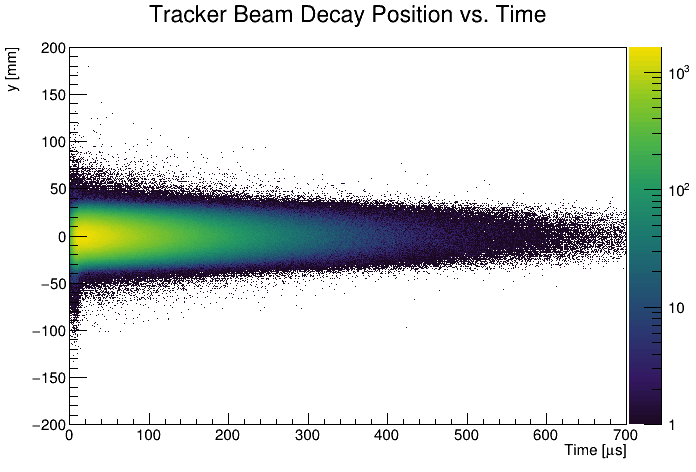

In [93]:
c = r.TCanvas()
#trackerBeamPos.Draw("lego2z")
trackerBeamPos.GetZaxis().SetRange(trackerBeamPos.GetZaxis().FindBin(station),trackerBeamPos.GetZaxis().FindBin(station))

hi = trackerBeamPos.Project3D("yx").Clone()
hi.SetTitle("Tracker Beam Decay Position vs. Time; Time [#mus]; y [mm]")
hi.Draw("colz")
c.SetLogz()
c.Draw()

---

### Lets get the beam position vs. time for the selected station

In [94]:
trackerBeamPos.GetZaxis().SetRange(trackerBeamPos.GetZaxis().FindBin(station),trackerBeamPos.GetZaxis().FindBin(station))
trackerBeamPos.Rebin3D(5,1,1)
widthDict = getWidths(trackerBeamPos.Project3D("yx"))

In [95]:
tlow = 10
thigh = 400
func,paramVec = fitfunc(0, [tlow,thigh],[15,-170,0.00053,-0.061]) 

fitresult = fitVector(widthDict['times'], widthDict[to_fit+"s"], func, None, widthDict[to_fit+"Errs"],nFit=2)
allFitResults[name+"_beam"] = fitresult

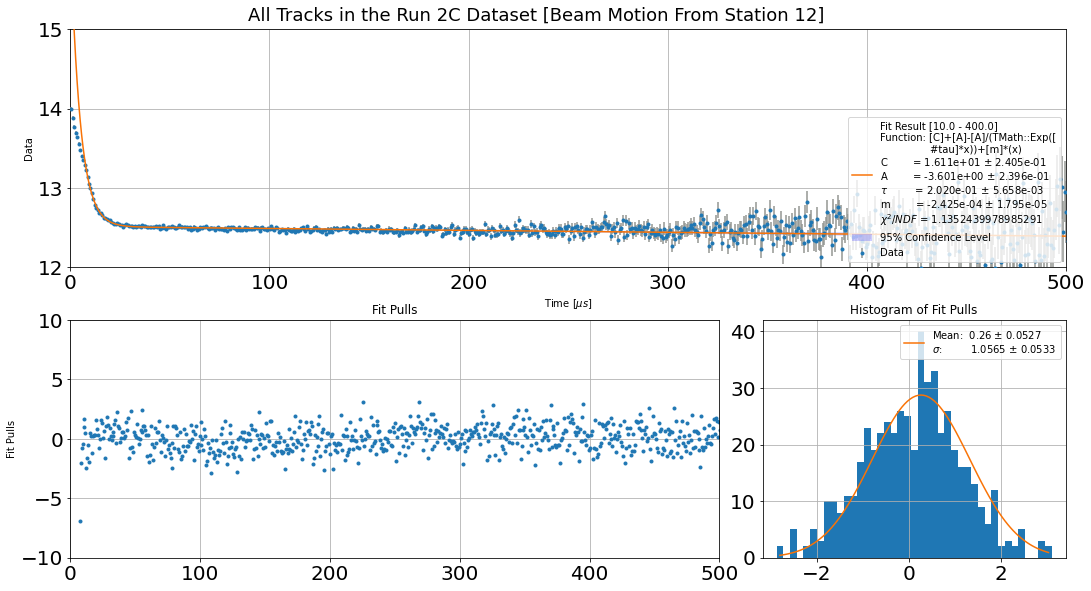

In [96]:
#fitresult.f.SetParameters(15,-170,0.00053,0.061)

fig,ax = fitresult.draw("All Tracks in the "+dataset+" Dataset [Beam Motion From Station "+str(station)+"]", 
                        yrange=[None, [-10,10]], fmti=".")
#ax[0].set_ylim(11,15)
for i in range(2):
    ax[i].set_xlim(0,500)
ax[0].set_ylim(12,15)
ax[0].set_xlabel(r"Time [$\mu s$]")

plt.savefig("./images/outputFits/"+to_fit+"/AllTracks_Beam_"+dataset+".png", bbox_inches="tight")
plt.show()

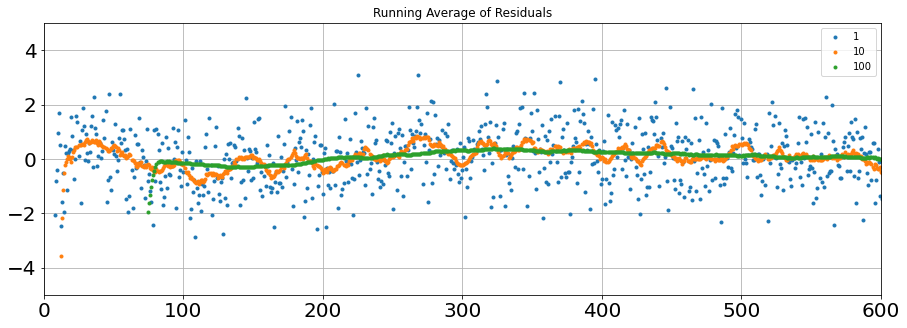

In [97]:
fig,ax = plt.subplots(figsize=(15,5))
fitresult.plotResiduals(ax, 1, ".", "1", 1)
fitresult.plotResiduals(ax, 1, ".", "10", 10)
fitresult.plotResiduals(ax, 1, ".", "100", 100)
plt.xlim(0,600)
plt.ylim(-5,5)
plt.grid()
plt.title("Running Average of Residuals")
plt.legend()
plt.show()

Restricting range of FFT to: [60, 300]


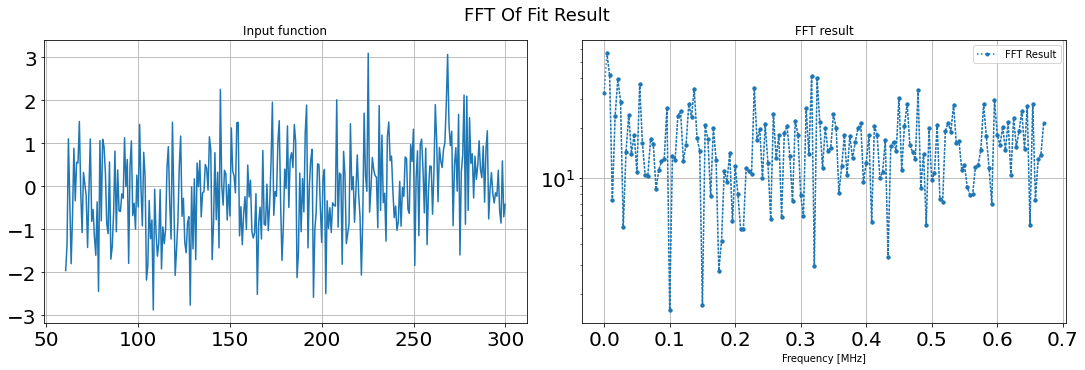

In [98]:
fitresult.fft([60,300],2)
plt.show()

---

### And the calo face position vs. time for the selected station

In [99]:
trackerCaloPos.GetZaxis().SetRange(trackerCaloPos.GetZaxis().FindBin(station),trackerCaloPos.GetZaxis().FindBin(station))
trackerCaloPos.Rebin3D(5,1,1)
widthDict = getWidths(trackerCaloPos.Project3D("yx"))

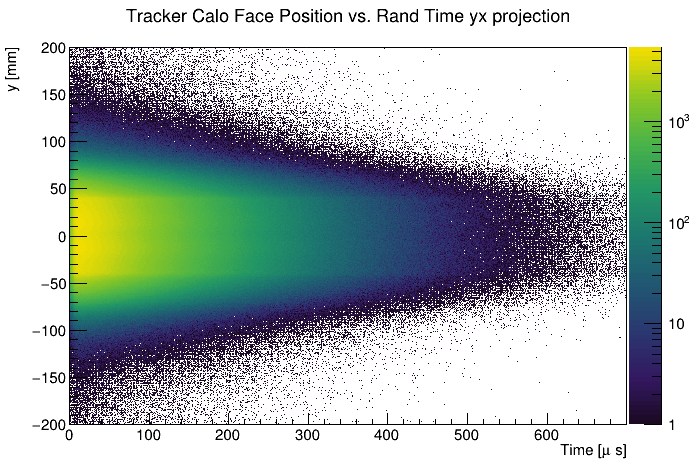

In [100]:
c = r.TCanvas()
hi = trackerCaloPos.Project3D("yx").Clone()
hi.Draw("colz")
c.SetLogz()
c.Draw()

In [101]:
tlow = 15
thigh = 550
func,paramVec = fitfunc(0, [tlow,thigh],[34, -3.5, 0.005, -0.005]) 

fitresult = fitVector(widthDict['times'], widthDict[to_fit+"s"], func, None, widthDict[to_fit+"Errs"])
allFitResults[name+"_calo"] = fitresult

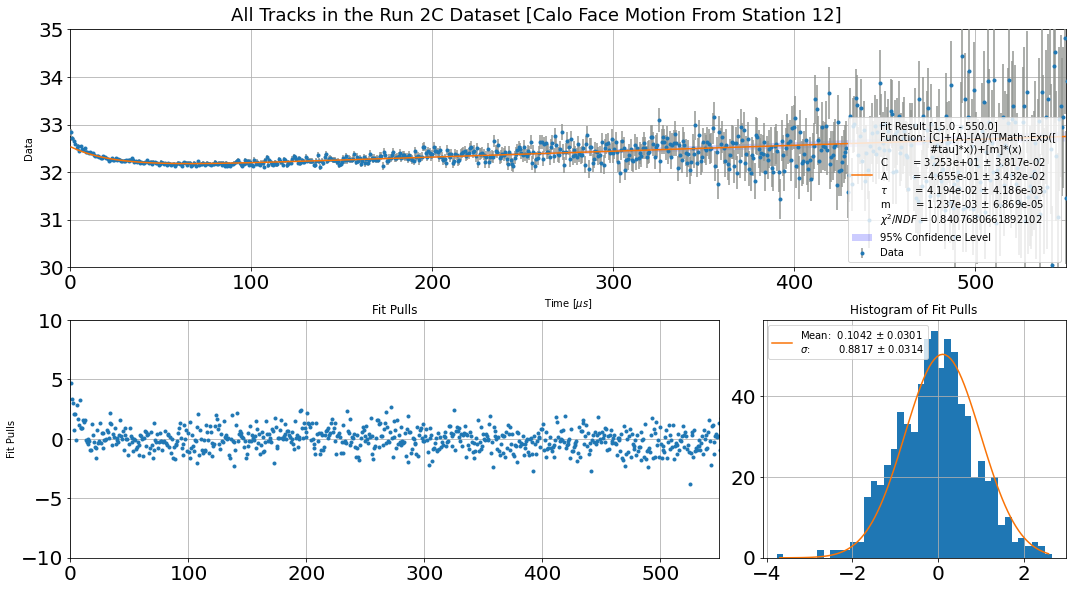

In [102]:
fig,ax = fitresult.draw("All Tracks in the "+dataset+" Dataset [Calo Face Motion From Station "+str(station)+"]", 
                        yrange=[None, [-10,10]], fmti=".")
ax[0].set_ylim(30,35)
for i in range(2):
    ax[i].set_xlim(0,550)
ax[0].set_xlabel(r"Time [$\mu s$]")

plt.savefig("./images/outputFits/"+to_fit+"/AllTracks_CaloFace_"+dataset+".png", bbox_inches="tight")

plt.show()

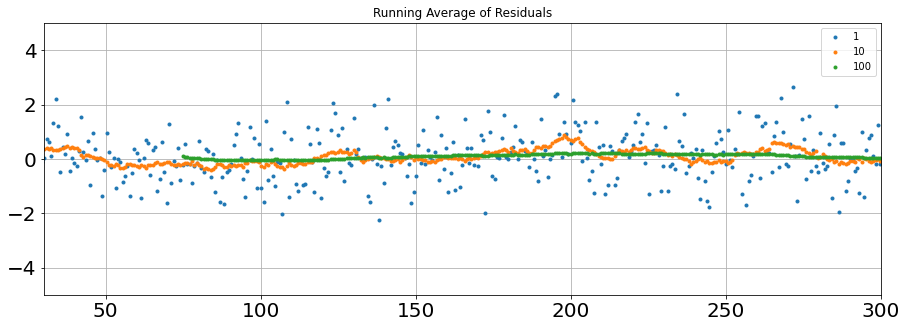

In [103]:
fig,ax = plt.subplots(figsize=(15,5))
fitresult.plotResiduals(ax, 1, ".", "1", 1)
fitresult.plotResiduals(ax, 1, ".", "10", 10)
fitresult.plotResiduals(ax, 1, ".", "100", 100)
plt.xlim(30,300)
plt.ylim(-5,5)
plt.grid()
plt.title("Running Average of Residuals")
plt.legend()
plt.show()

Restricting range of FFT to: [20, 300]


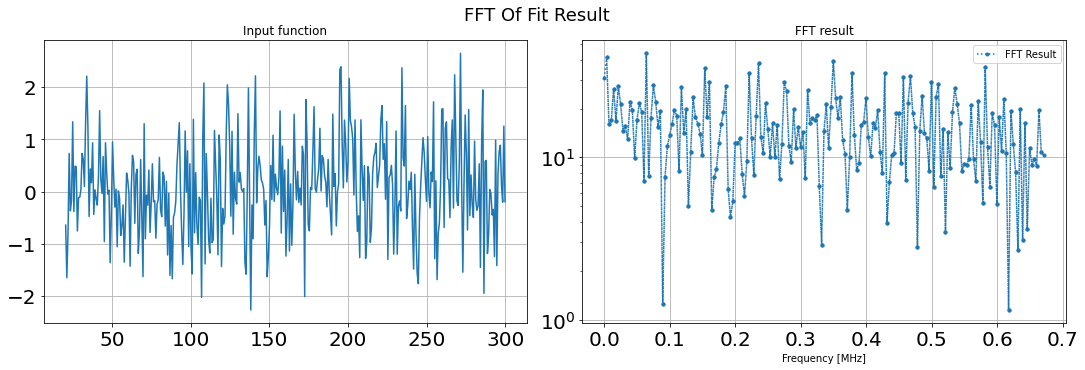

In [104]:
fitresult.fft([20,300],2)
plt.show()

---

### Calo face position vs. time (from tracker, but ignoring radial field)

In [105]:
trackerCaloPos_noRadialFieldRand = f.Get("trackerCaloPos_noRadialFieldRand").Clone()

trackerCaloPos_noRadialFieldRand.GetZaxis().SetRange(
    trackerCaloPos_noRadialFieldRand.GetZaxis().FindBin(station),
    trackerCaloPos_noRadialFieldRand.GetZaxis().FindBin(station))
trackerCaloPos_noRadialFieldRand.GetYaxis().SetRangeUser(-75,75)
trackerCaloPos_noRadialFieldRand.Rebin3D(5,1,1)
widthDict = getWidths(trackerCaloPos_noRadialFieldRand.Project3D("yx"))

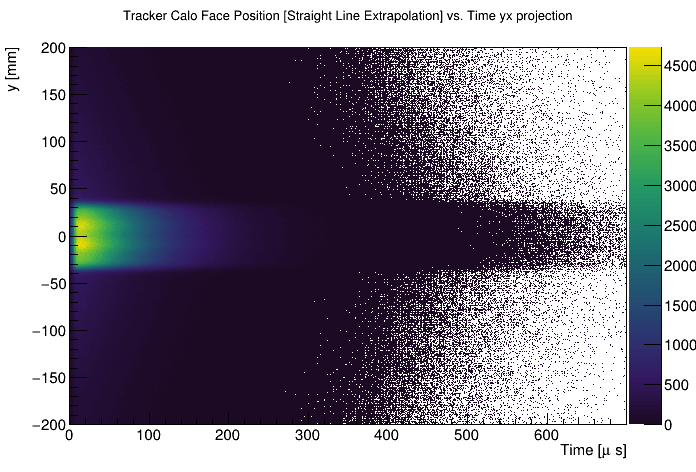

In [106]:
c = r.TCanvas()
trackerCaloPos_noRadialFieldRand.Project3D("yx").Draw("colz")
c.Draw()

In [107]:
tlow = 15
thigh = 550

func,paramVec = fitfunc(0, [tlow,thigh],[65, -3.5, 0.005, 0.005]) 

fitresult = fitVector(widthDict['times'], widthDict[to_fit+"s"], func, None, widthDict[to_fit+"Errs"])
allFitResults[name+"_calo_noRadialField"] = fitresult

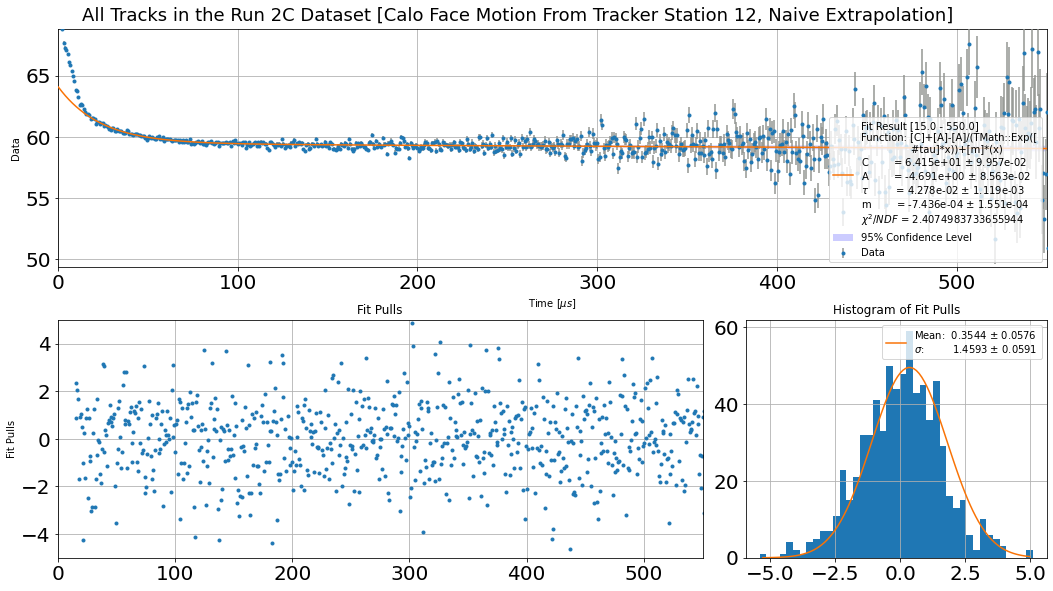

In [108]:
fig,ax = fitresult.draw(("All Tracks in the "+dataset+" Dataset [Calo Face Motion From Tracker Station "
                         +str(station)+", Naive Extrapolation]"), 
                        yrange=[None, [-5,5]], fmti=".", do_pulls=True)
#ax[0].set_ylim(-2,2)
for i in range(2):
    ax[i].set_xlim(0,550)
#ax[0].set_ylim(18,22)
ax[0].set_xlabel(r"Time [$\mu s$]")

plt.savefig("./images/outputFits/"+to_fit+"/AllTracks_CaloFace_Naive_"+dataset+".png", bbox_inches="tight")

plt.show()

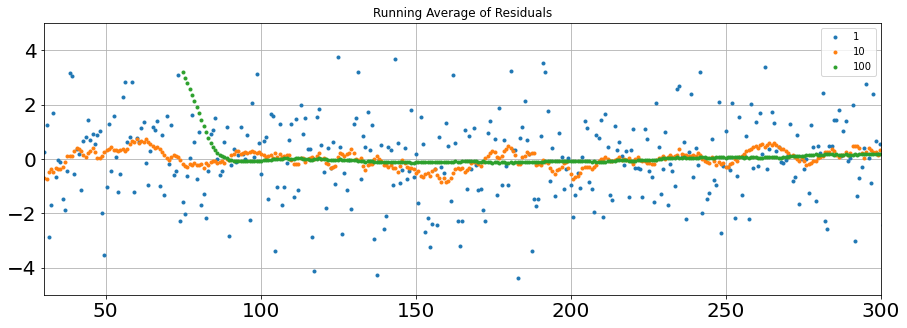

In [109]:
fig,ax = plt.subplots(figsize=(15,5))
fitresult.plotResiduals(ax, 1, ".", "1", 1)
fitresult.plotResiduals(ax, 1, ".", "10", 10)
fitresult.plotResiduals(ax, 1, ".", "100", 100)
plt.xlim(30,300)
plt.ylim(-5,5)
plt.grid()
plt.title("Running Average of Residuals")
plt.legend()
plt.show()

Restricting range of FFT to: [30, 300]


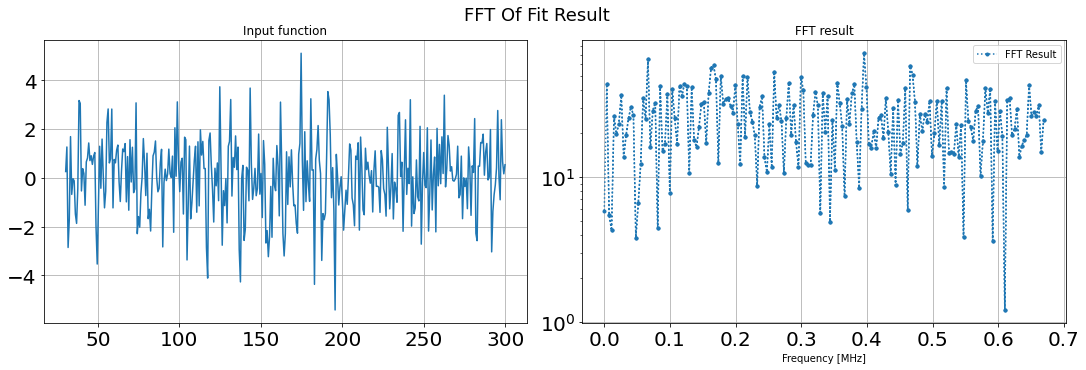

In [110]:
fitresult.fft([30,300],2)
plt.show()

---

### Difference in tracks vs time



In [111]:
trackerDeltaPosition_vs_Time = f.Get("trackerDeltaPosition_vs_Time").Clone()

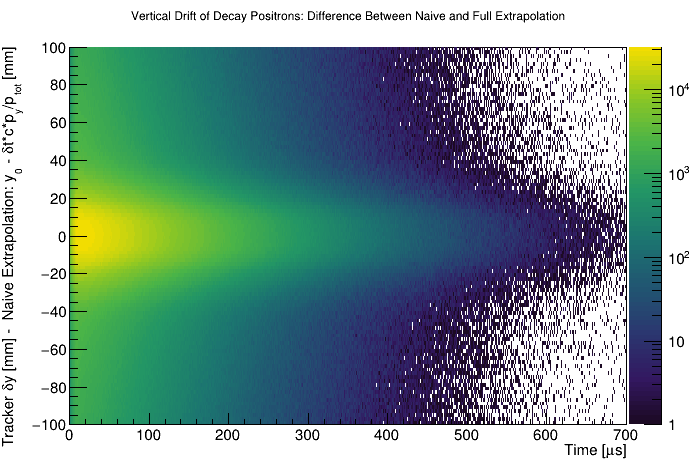

In [112]:
c = r.TCanvas()
trackerDeltaPosition_vs_Time.Draw("colz")
c.SetLogz()
c.Draw()

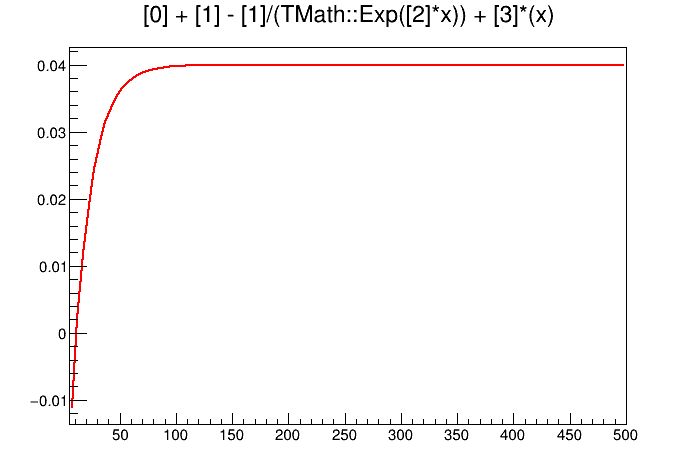

In [113]:
func = fitfunc(0,[5,500],[-0.04,0.08,0.06,0])[0]
func.Draw()
c.Draw()

Info in <TCanvas::Print>: png file ./images/outputFits/width/AllTracks_Naive_Minus_Full_Extrapolation_Run 2C.png has been created


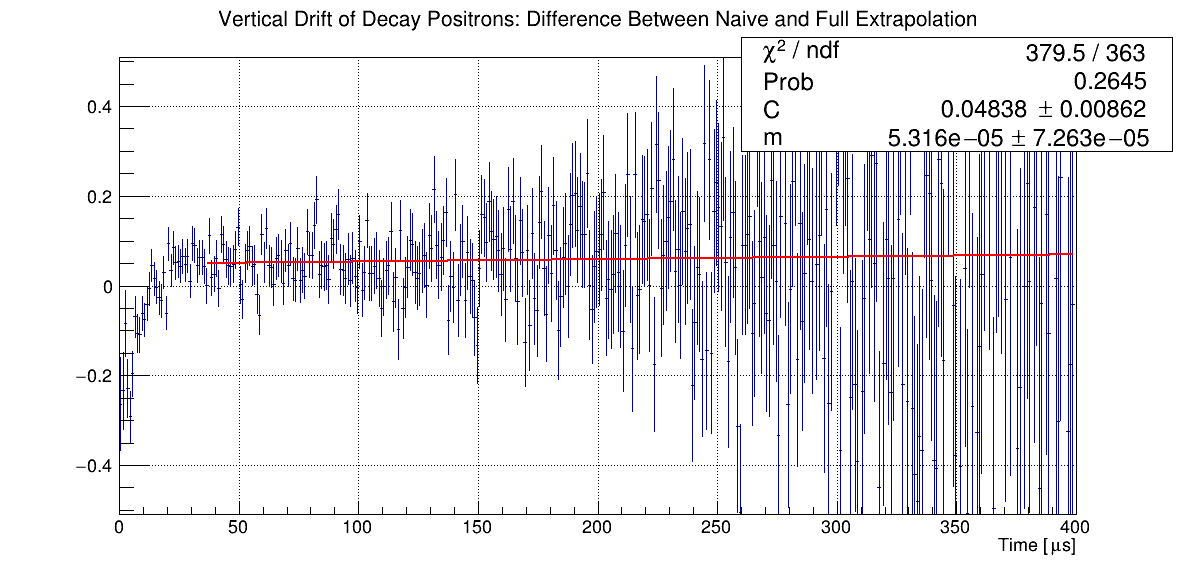

In [114]:
c = r.TCanvas("c","c",1200,600)
h2 = trackerDeltaPosition_vs_Time.ProfileX()
r.gStyle.SetOptFit(11111)
h2.Draw("")
func = fitfunc(1,[35,400],[-0.04,0.08,0.06,0])[0]
for i in range(2):
    h2.Fit(func,"REMBQ")
func.Draw("same")
h2.GetYaxis().SetRangeUser(-0.51,0.51)
h2.GetXaxis().SetRangeUser(0,400)
c.SetLogz()
c.SetGrid()
c.Print("./images/outputFits/"+to_fit+"/AllTracks_Naive_Minus_Full_Extrapolation_"+dataset+".png")
c.Draw()

---

# And now the calo only information

In [115]:
name = 'clusters'
f = fs[name]
f.ls()

TFile**		/home/jlab/g-2/caloTrackMatching/data/run2c/clusters_run2c.root	
 TFile*		/home/jlab/g-2/caloTrackMatching/data/run2c/clusters_run2c.root	
  KEY: TH3F	clusters13;1	clusters
  KEY: TH3F	randclusters13;1	time randomized clusters
  KEY: TH3F	clusters19;1	clusters
  KEY: TH3F	randclusters19;1	time randomized clusters


In [116]:
clusters = f.Get("clusters"+str(calo)).Clone()
randclusters = f.Get("randclusters"+str(calo)).Clone()

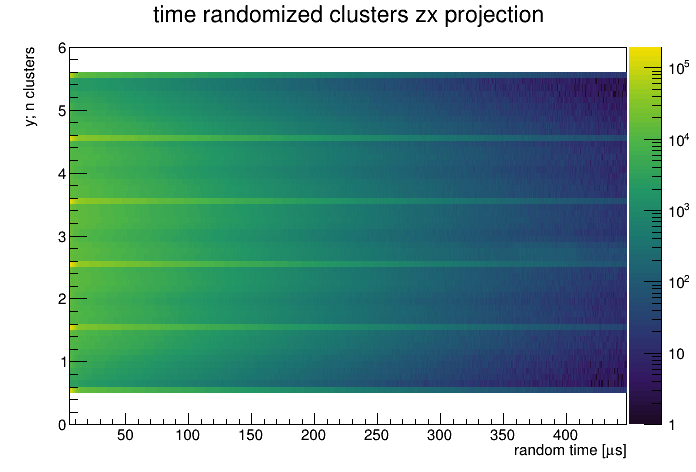

In [117]:
c = r.TCanvas()
randclusters.Project3D("zx").Draw("colz")
c.SetLogz()
c.Draw()

---
### Calo face position

In [118]:
randclusters.GetYaxis().SetRange(randclusters.GetYaxis().FindBin(1000),randclusters.GetYaxis().FindBin(2400))
#randclusters.Rebin3D(5,1,1)
widthDict = getWidths(randclusters.Project3D("zx"), scale=25, offset=3)

In [119]:
tlow = 30
thigh = 300

func,paramVec = fitfunc(1, [tlow,thigh]) 

fitresult = fitVector(widthDict['times'], widthDict[to_fit+"s"], func, None, widthDict[to_fit+"Errs"])
allFitResults[name+"_calo"] = fitresult

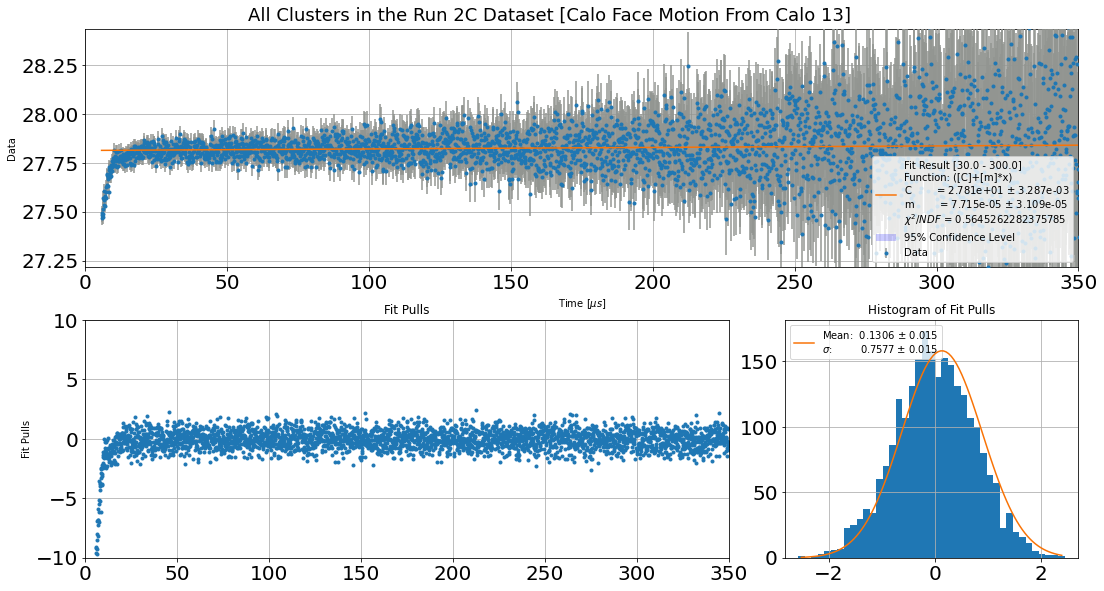

In [120]:
fig,ax = fitresult.draw("All Clusters in the "+dataset+" Dataset [Calo Face Motion From Calo "+str(calo)+"]", 
                        yrange=[None, [-10,10]], fmti=".")
#ax[0].set_ylim(-2,30)
#ax[0].set_xlim(0,50)
for i in range(2):
    ax[i].set_xlim(0,350)
ax[0].set_xlabel(r"Time [$\mu s$]")

plt.savefig("./images/outputFits/"+to_fit+"/AllClusters_"+dataset+".png", bbox_inches="tight")

plt.show()

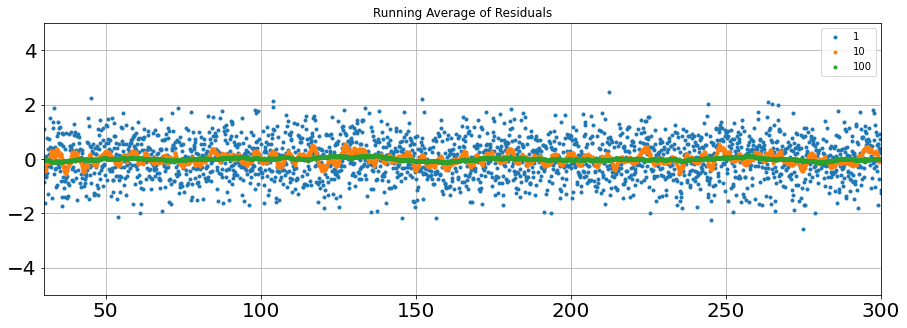

In [121]:
fig,ax = plt.subplots(figsize=(15,5))
fitresult.plotResiduals(ax, 1, ".", "1", 1)
fitresult.plotResiduals(ax, 1, ".", "10", 10)
fitresult.plotResiduals(ax, 1, ".", "100", 100)
plt.xlim(30,300)
plt.ylim(-5,5)
plt.grid()
plt.title("Running Average of Residuals")
plt.legend()
plt.show()

Restricting range of FFT to: [30, 300]


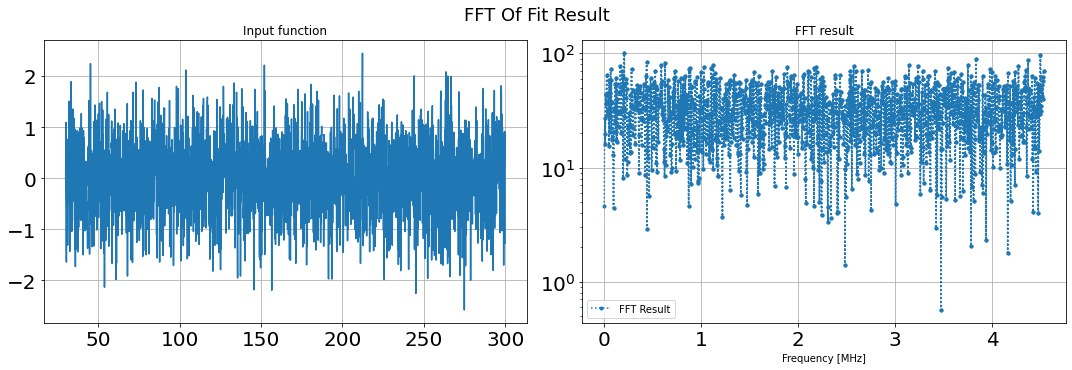

(array([ 0.        ,  0.0037032 ,  0.00740639, ..., -0.01110959,
        -0.00740639, -0.0037032 ]),
 array([  4.56470328+2.13162821e-14j,   1.68536019-1.95077271e+01j,
        -20.00400039+1.85276527e+01j, ...,  16.00109192+1.16501219e+00j,
        -20.00400039-1.85276527e+01j,   1.68536019+1.95077271e+01j]))

In [122]:
fitresult.fft([30,300],2)

---

# And finally the calo-matched information

In [123]:
name = 'matchedTracks'
f = fs[name]
f.ls()

TFile**		/home/jlab/g-2/caloTrackMatching/data/run2c/matchedTracks_run2c.root	
 TFile*		/home/jlab/g-2/caloTrackMatching/data/run2c/matchedTracks_run2c.root	
  OBJ: TH3I	trackerBeamPosRand	Tracker Beam Position vs. Rand Time : 0 at: 0x56191b3af4f0
  OBJ: TH3I	trackerCaloPosRand	Tracker Calo Face Position vs. Rand Time : 0 at: 0x5619181fc110
  OBJ: TH3I	trackerCaloPos_noRadialField	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time : 0 at: 0x561917ecdd00
  OBJ: TH2D	trackerBeamPosRand_yx	Tracker Beam Position vs. Rand Time yx projection : 0 at: 0x561918532510
  OBJ: TH1D		Tracker Beam Position vs. Rand Time yx projection : 0 at: 0x561917e3b190
  OBJ: TH2D	trackerCaloPosRand_yx	Tracker Calo Face Position vs. Rand Time yx projection : 0 at: 0x561917ec7ad0
  OBJ: TH2D	trackerCaloPosRand_yx	Tracker Calo Face Position vs. Rand Time yx projection : 0 at: 0x561918d4ae70
  OBJ: TH3I	trackerCaloPos_noRadialFieldRand	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time

In [124]:
trackerBeamPos_match = f.Get("trackerBeamPosRand").Clone()
trackerCaloPos_match = f.Get("trackerCaloPosRand").Clone()
caloCaloPos_match = f.Get("caloCaloPosRand").Clone()
trackerCaloPos_noRadialField_match = f.Get("trackerCaloPos_noRadialField").Clone()
trackerCaloPos_noRadialFieldRand_match = f.Get("trackerCaloPos_noRadialFieldRand").Clone()

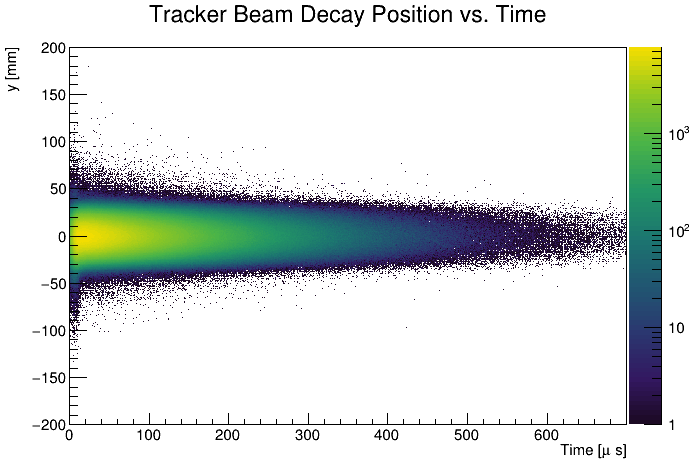

In [125]:
c = r.TCanvas()
#trackerBeamPos.Draw("lego2z")
trackerBeamPos_match.GetZaxis().SetRange(trackerBeamPos_match.GetZaxis().FindBin(station),
                                         trackerBeamPos_match.GetZaxis().FindBin(station))

hi = trackerBeamPos_match.Project3D("yx").Clone()
hi.SetTitle("Tracker Beam Decay Position vs. Time")
hi.Draw("colz")
c.SetLogz()
c.Draw()

---

### Beam position vs. time

In [126]:
trackerBeamPos_match.GetZaxis().SetRange(trackerBeamPos_match.GetZaxis().FindBin(station),
                                         trackerBeamPos_match.GetZaxis().FindBin(station))
#trackerBeamPos_match.Rebin3D(5,1,1)
widthDict = getWidths(trackerBeamPos_match.Project3D("yx"))

In [127]:
tlow = 10
thigh = 300

func,paramVec = fitfunc(0, [tlow,thigh],[15,-170,0.00053,-0.061]) 

fitresult = fitVector(widthDict['times'], widthDict[to_fit+"s"], func, None, widthDict[to_fit+"Errs"])
allFitResults[name+"_beam"] = fitresult

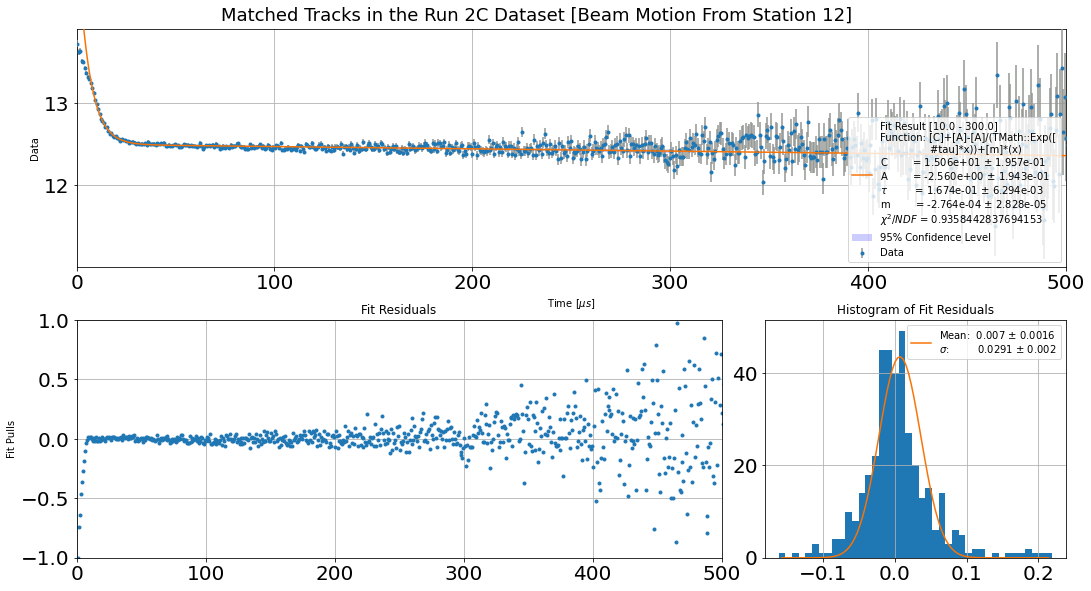

In [128]:
fig,ax = fitresult.draw("Matched Tracks in the "+dataset+" Dataset [Beam Motion From Station "+str(station)+"]", 
                        yrange=[None, [-1,1]], fmti=".", do_pulls=False)
#ax[0].set_ylim(-2,2)
#ax[0].set_xlim(0,50)
for i in range(2):
    ax[i].set_xlim(0,500)
ax[0].set_xlabel(r"Time [$\mu s$]")

plt.savefig("./images/outputFits/"+to_fit+"/MatchedTracks_BeamMotion_"+dataset+".png", bbox_inches="tight")

plt.show()

---

### Calo face position vs. time (from tracker)

In [129]:
trackerCaloPos_match.GetZaxis().SetRange(trackerCaloPos_match.GetZaxis().FindBin(station),
                                         trackerCaloPos_match.GetZaxis().FindBin(station))
widthDict = getWidths(trackerCaloPos_match.Project3D("yx"))

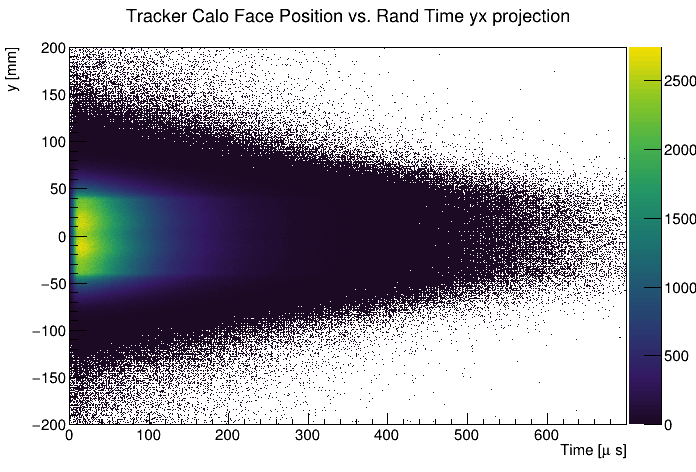

In [130]:
c = r.TCanvas()
#trackerCaloPos_noRadialField.Project3D("yx").Draw("colz")
trackerCaloPos_match.Project3D("yx").Draw("colz")
trackerCaloPos_match.SetTitle("Normal Extrapolation to Calo Face")
c.Draw()

In [131]:
tlow = 10
thigh = 500

func,paramVec = fitfunc(0, [tlow,thigh],[35,-170,0.00053,-0.061]) 

fitresult = fitVector(widthDict['times'], widthDict[to_fit+"s"], func, None, widthDict[to_fit+"Errs"])
allFitResults[name+"_calo"] = fitresult

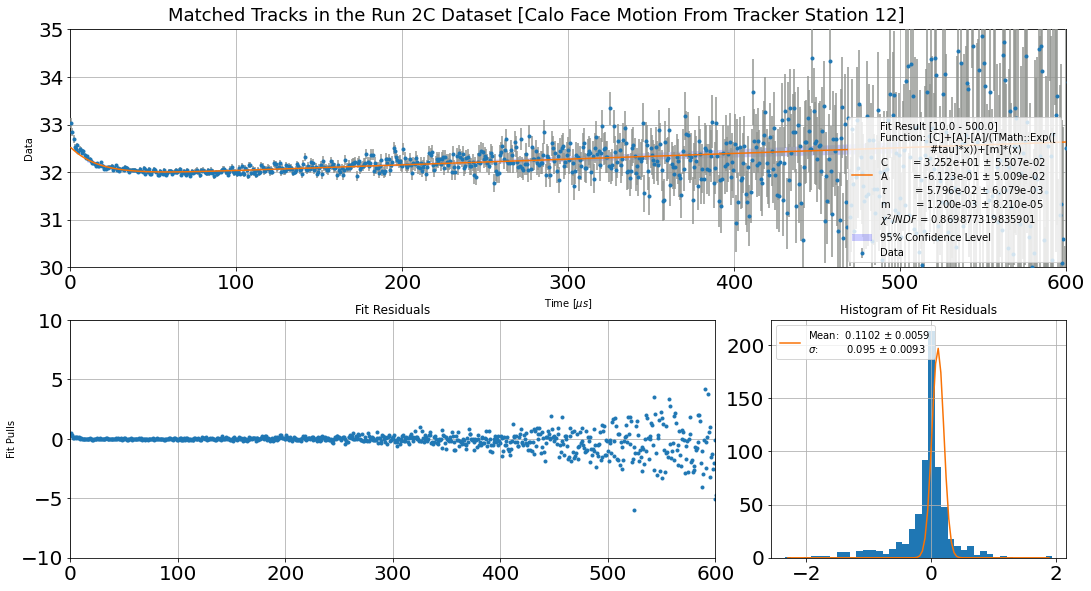

In [132]:
fig,ax = fitresult.draw("Matched Tracks in the "+dataset+" Dataset [Calo Face Motion From Tracker Station "+str(station)+"]", 
                        yrange=[[30,35], [-10,10]], fmti=".", do_pulls=False)
#ax[0].set_ylim(-2,2)
for i in range(2):
    ax[i].set_xlim(0,600)
ax[0].set_xlabel(r"Time [$\mu s$]")

plt.savefig("./images/outputFits/"+to_fit+"/MatchedTracks_CaloFace_"+dataset+".png", bbox_inches="tight")

plt.show()

---

### Calo face position vs. time (from tracker, but ignoring radial field)

In [133]:
trackerCaloPos_noRadialFieldRand_match.GetZaxis().SetRange(
    trackerCaloPos_noRadialFieldRand_match.GetZaxis().FindBin(station),
    trackerCaloPos_noRadialFieldRand_match.GetZaxis().FindBin(station))
widthDict = getWidths(trackerCaloPos_noRadialFieldRand_match.Project3D("yx"))

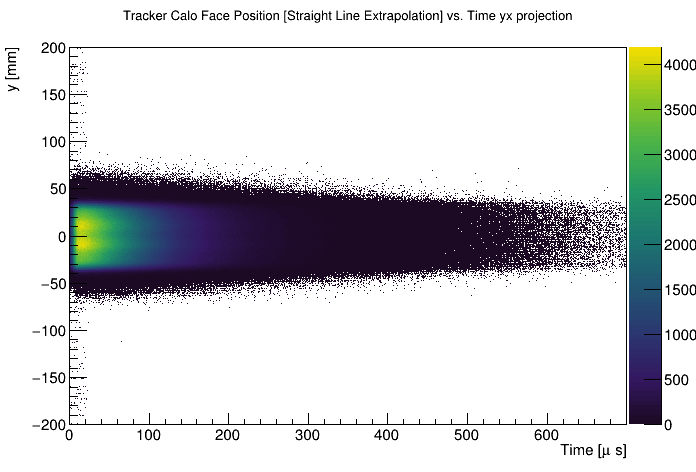

In [134]:
c = r.TCanvas()
#trackerCaloPos_noRadialField.Project3D("yx").Draw("colz")
trackerCaloPos_noRadialFieldRand_match.Project3D("yx").Draw("colz")
c.Draw()

In [135]:
tlow = 10
thigh = 300

func,paramVec = fitfunc(0, [tlow,thigh], [19, -3.5, 0.0005, 0.005]) 

fitresult = fitVector(widthDict['times'], widthDict[to_fit+"s"], func, None, widthDict[to_fit+"Errs"])
allFitResults[name+"_calo_noRadialField"] = fitresult

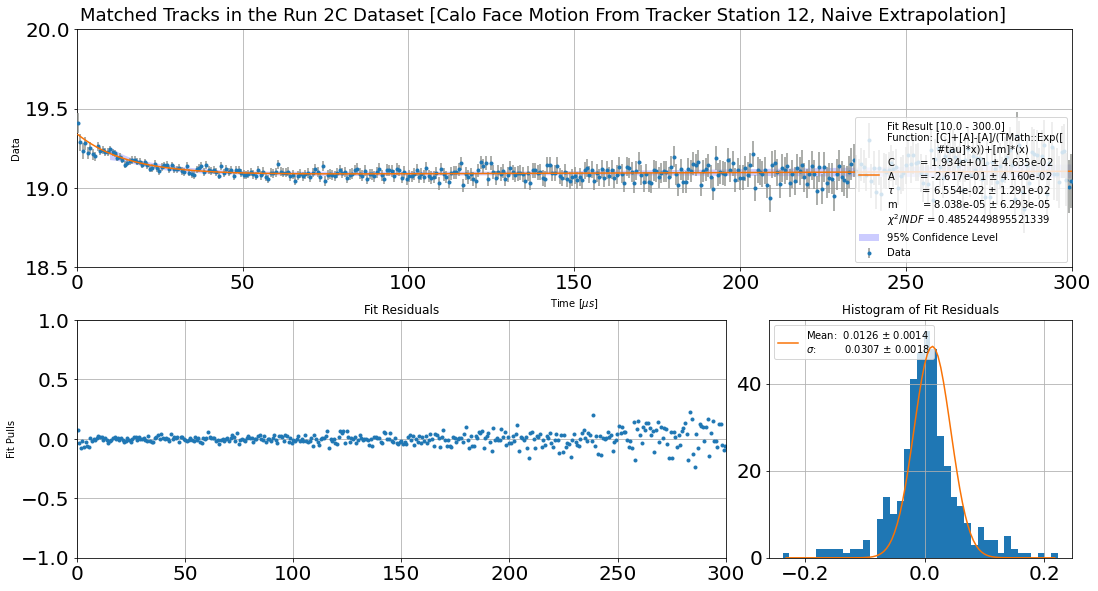

In [136]:
fig,ax = fitresult.draw("Matched Tracks in the Run 2C Dataset [Calo Face Motion From Tracker Station "+str(station)+", Naive Extrapolation]", 
                        yrange=[None, [-10,10]], fmti=".", do_pulls=False)
ax[0].set_ylim(18.5,20)
ax[1].set_ylim(-1,1)
for i in range(2):
    ax[i].set_xlim(0,300)
ax[0].set_xlabel(r"Time [$\mu s$]")

plt.savefig("./images/outputFits/"+to_fit+"/MatchedTracks_CaloFace_Naive_"+dataset+".png", bbox_inches="tight")

plt.show()

---

### Calo face position vs. time (from clusters)

In [137]:
caloCaloPos_match.GetZaxis().SetRange(caloCaloPos_match.GetZaxis().FindBin(station),
                                      caloCaloPos_match.GetZaxis().FindBin(station))
widthDict = getWidths(caloCaloPos_match.Project3D("yx"))

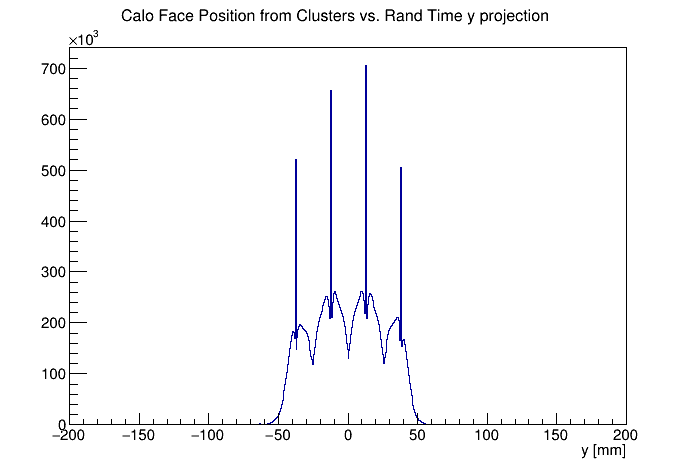

In [138]:
c = r.TCanvas()
#trackerCaloPos_noRadialField.Project3D("yx").Draw("colz")
caloCaloPos_match.Project3D("y").Draw("colz")
c.Draw()

In [139]:
tlow = 30
thigh = 300

func,paramVec = fitfunc(1, [tlow,thigh]) 

fitresult = fitVector(widthDict['times'], widthDict[to_fit+"s"], func, None, widthDict[to_fit+"Errs"])
allFitResults[name+"_clusters"] = fitresult

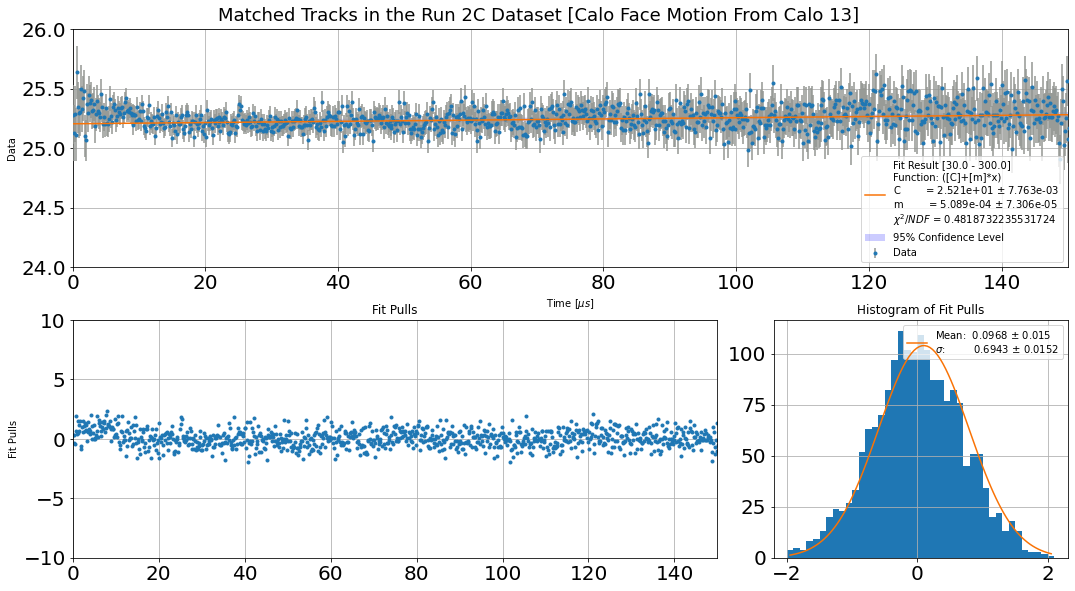

In [140]:
fig,ax = fitresult.draw("Matched Tracks in the "+dataset+" Dataset [Calo Face Motion From Calo "+str(calo)+"]", 
                        yrange=[None, [-10,10]], fmti=".")
ax[0].set_ylim(24,26)
#ax[0].set_xlim(0,50)
for i in range(2):
    ax[i].set_xlim(0,150)
ax[0].set_xlabel(r"Time [$\mu s$]")

plt.savefig("./images/outputFits/"+to_fit+"/MatchedTracks_Clusters_"+dataset+".png", bbox_inches="tight")

plt.show()

---

# Now lets compare the fit results from these datasets

In [141]:
print(allFitResults)

{'tracks_beam': <python_fit.fitVector object at 0x7fc0d5b532d0>, 'tracks_calo': <python_fit.fitVector object at 0x7fc0d5e81990>, 'tracks_calo_noRadialField': <python_fit.fitVector object at 0x7fc0d62f46d0>, 'clusters_calo': <python_fit.fitVector object at 0x7fc0d6459d50>, 'matchedTracks_beam': <python_fit.fitVector object at 0x7fc0d62779d0>, 'matchedTracks_calo': <python_fit.fitVector object at 0x7fc0d1622210>, 'matchedTracks_calo_noRadialField': <python_fit.fitVector object at 0x7fc0d5aa2b90>, 'matchedTracks_clusters': <python_fit.fitVector object at 0x7fc0d1389210>}


In [142]:
pars = []
parErrs = []
fitnames = []
allNames = []

for name,fit in allFitResults.items():
    print(name)
    fitnames.append(name)
    pars.append(fit.pars)
    parErrs.append(fit.parErrs)
    allNames.append( fit.parNames() )
print(allNames)

tracks_beam
tracks_calo
tracks_calo_noRadialField
clusters_calo
matchedTracks_beam
matchedTracks_calo
matchedTracks_calo_noRadialField
matchedTracks_clusters
[['C', 'A', '$\\tau$ ', 'm'], ['C', 'A', '$\\tau$ ', 'm'], ['C', 'A', '$\\tau$ ', 'm'], ['C', 'm'], ['C', 'A', '$\\tau$ ', 'm'], ['C', 'A', '$\\tau$ ', 'm'], ['C', 'A', '$\\tau$ ', 'm'], ['C', 'm']]


In [143]:
parDict = {}
parErrDict = {}
histNames = {}
for names in allNames:
    for name in names:
        parDict[name] = []
        parErrDict[name] = []
        histNames[name] = []
for i, names in enumerate(allNames):
    for j, name in enumerate(names):
        parDict[name].append( pars[i][j] )
        parErrDict[name].append( parErrs[i][j] )
        histNames[name].append(fitnames[i])

In [144]:
print(parDict)
print(histNames)

{'C': [16.114364020809898, 32.53327782807179, 64.1542466264124, 27.813726885630487, 15.058653458312678, 32.524165496829056, 19.34262831239904, 25.206306756804494], 'A': [-3.6014531401486094, -0.46547565480173586, -4.6908194684813465, -2.5604329111526276, -0.6123416140278352, -0.2616621389597815], '$\\tau$ ': [0.20201264691553933, 0.04194168903022922, 0.04277812287782371, 0.16735585955490231, 0.05796299693140273, 0.06554420703996114], 'm': [-0.0002424910830101961, 0.0012370308184538692, -0.0007436485185346837, 7.714839149722444e-05, -0.000276429932659567, 0.0012001631596411711, 8.037820042777845e-05, 0.0005089374297179162]}
{'C': ['tracks_beam', 'tracks_calo', 'tracks_calo_noRadialField', 'clusters_calo', 'matchedTracks_beam', 'matchedTracks_calo', 'matchedTracks_calo_noRadialField', 'matchedTracks_clusters'], 'A': ['tracks_beam', 'tracks_calo', 'tracks_calo_noRadialField', 'matchedTracks_beam', 'matchedTracks_calo', 'matchedTracks_calo_noRadialField'], '$\\tau$ ': ['tracks_beam', 'trac

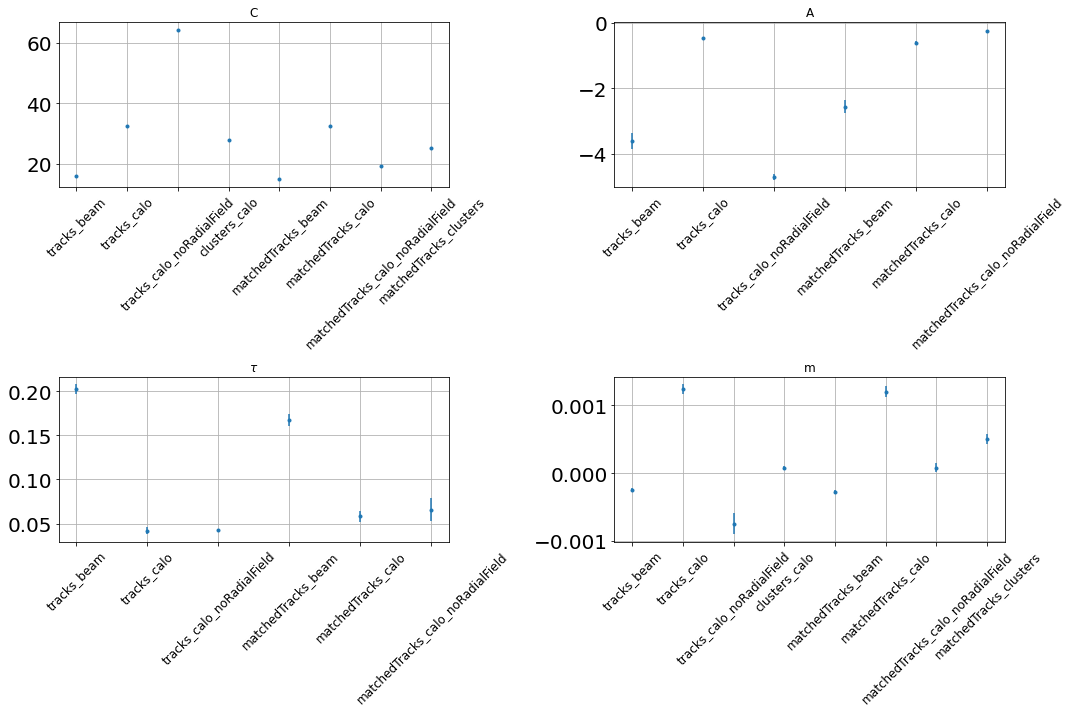

In [145]:
fig,axs = plt.subplots(int(len(parDict)/2),2,figsize=(15,10), sharex=False)
if(len(parDict) > 2):
    ax = flatten2dArray(axs)
else:
    ax = axs

for i, name in enumerate(parDict):
    axi = ax[i]
    thispar = parDict[name]
    axi.errorbar(histNames[name], thispar, yerr=parErrDict[name], fmt=".")
    axi.grid()
    axi.set_title(name)
    plt.sca(axi)
    plt.xticks(rotation=45, fontsize=12,)
plt.tight_layout()
plt.show()

m


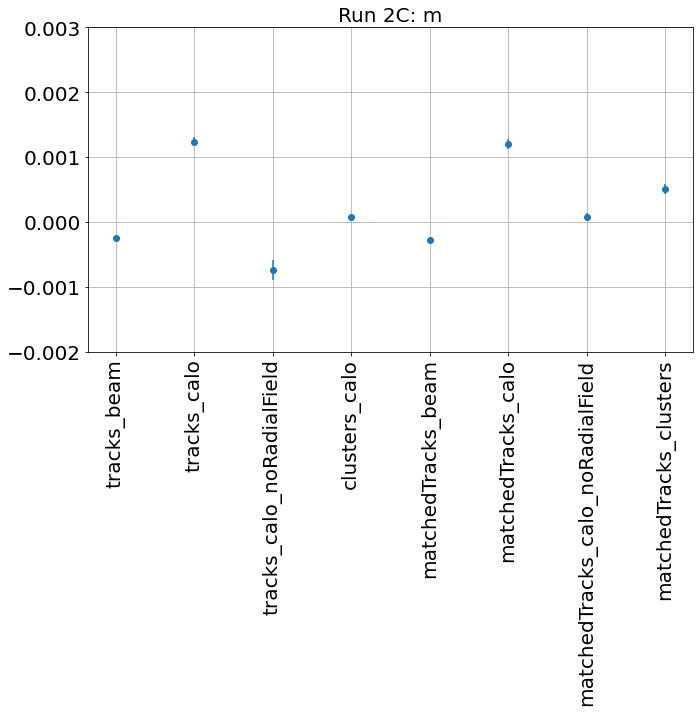

In [146]:
name = allNames[0][3]
print(name)
fig,ax = plt.subplots(figsize=(10,10))
axi = ax
thispar = parDict[name]
#axi.plot(histNames[name], thispar,".")
axi.errorbar(histNames[name], thispar, yerr=parErrDict[name], fmt="o")
axi.grid()
axi.set_title(dataset+": "+name,fontsize=20)
plt.sca(axi)
plt.xticks(rotation=90,)
plt.tight_layout()
plt.ylim(-0.002,0.003)
#plt.ylim(-0.015,0.025)
#plt.ylim(-0.02,0.04)
#plt.ylim(-0.015,0.025)
plt.show()

In [147]:
pars_byPar = [x for x in zip(*pars)]
parErrs_byPar = [x for x in zip(*parErrs)]

NameError: name 'parNames' is not defined

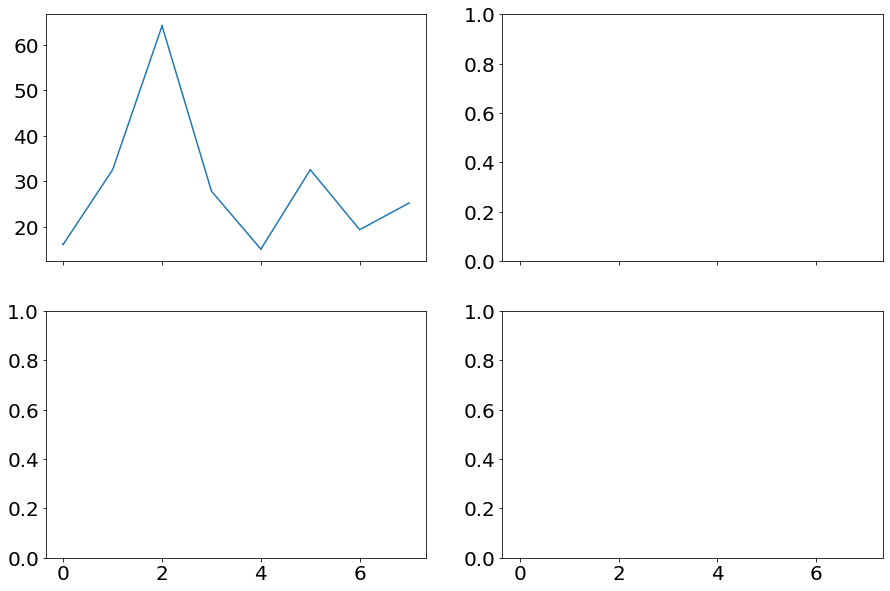

In [148]:
fig, axs = plt.subplots(int(len(pars[0])/2),2,figsize=(15,10), sharex=True)
if(len(pars[0]) > 2):
    ax = flatten2dArray(axs)
else:
    ax = axs
for i, axi in enumerate(ax):
    xpoints = [x for x in range(len(fitnames))]
    axi.errorbar(xpoints, pars_byPar[i], yerr=parErrs_byPar[i])
    axi.set_title(parNames[i])
    plt.sca(axi)
    plt.xticks(xpoints, labels=fitnames,rotation=90)
    axi.grid()
plt.tight_layout()
plt.suptitle("Parameters from All Fits: "+str(func.GetExpFormula()), y=1.03, fontsize=20)
plt.show()